# Modelo Econométrico de Mundell–Fleming

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import shapiro
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan, normal_ad

# 1. Planteamiento del problema


* Pregunta de investigación:

¿Cómo influyen las variables macroeconómicas PBI, reservas internacionales netas, inflación, exportaciones y tasa de referencia en la determinación del tipo de cambio en el Perú durante el periodo trimestral 2007–2025 según el modelo Mundell-Fleming?

* Hipótesis teórica:





| Variable                           |   Símbolo  | Signo esperado | Justificación                                                                       |
| ---------------------------------- | :--------: | :------------: | ------------------------------------------------------------------------------------------ |
| **Producto Bruto Interno**         |     PBI    |     **(+)**    | Un mayor PBI refleja mayor actividad económica, elevando la demanda de divisas y presionando al alza el tipo de cambio.                  |
| **Reservas Internacionales Netas** |     RIN    |     **(−)**    | Más reservas permiten intervenir y estabilizar el mercado cambiario, apreciando la moneda. |
| **Inflación**                      |    INFLA   |     **(+)**    | Una inflación alta reduce el poder adquisitivo y presiona a la depreciación del sol.       |
| **Exportaciones**                  |    EXPO    |     **(−)**    | Más exportaciones aumentan la oferta de divisas, reduciendo el tipo de cambio.             |
| **Tasa de referencia (BCRP)**      | REFERENCIA |     **(−)**    | Una tasa alta atrae capitales y fortalece el sol.                                          |
| **Crisis Global (2008–2009)**      |     D1     |        —       | Refleja el impacto externo que generó volatilidad en el tipo de cambio.                    |
| **Pandemia (2020–2021)**           |     D2     |        —       | Captura el efecto de la crisis sanitaria sobre la depreciación del sol.                    |
| **Crisis Política (2022–2023)**    |     D3     |        —       | Representa la inestabilidad interna que afectó la confianza cambiaria.                     |


# 2. Selección del modelo econométrico

$$
\ln(\text{Tipo_cambio}_t) = \beta_0 + \beta_1 \ln(\text{PBI}_t) + \beta_2 \ln(\text{RIN}_t) + \beta_3 \ln(\text{Inflación}_t) + \beta_4 \ln(\text{Exportaciones}_t) + \beta_5 \ln(\text{tasa_Referencia}_t) + \beta_6 \ln(\text{dummy_1}_t) + \beta_7 \ln(\text{dummy_2}_t) + \beta_8 \ln(\text{dummy_3}_t) + u_t
$$

* IS / demanda agregada: PBI y Exporacion afectan la demanda de divisas y la balanza comercial.

* BP / cuenta financiera: RIN (reservas) refleja la posición externa y la intervención del banco central.

* LM / política monetaria y expectativas: Tasa Referencia y Inflacion capturan el canal monetario y efecto sobre flujo de capitales/expectativas.

* Las dummies controlan estacionalidad o shocks periódicos.

## 3. Recolección de datos (BCRP):




*  PN01216PM: Tipo de cambio
*  PN02550AQ: PBI
*  PN06481IM: RIN
*  PN01273PM: Inflacion
*  PN38714BM: Exportacion
*  PD04722MM: Tasa Referencia



# 4. Análisis exploratorio

In [3]:
## A) CARGAR LOS DATOS
df = pd.read_excel('/content/datos.xlsx')
print(df)

   tiempo  tipo_cambio            PBI           RIN  inflacion  exportacion  \
0    T107       3.1830   73354.118000  18427.000000   0.415396  1918.260261   
1    T207       3.1680   80625.953000  21528.000000   0.801774  2240.002288   
2    T307       3.0853   80699.632000  22827.000000   2.403772  2546.659639   
3    T407       2.9982   85013.297000  27689.000000   3.497492  2659.750854   
4    T108       2.7467   81913.210356  33576.000000   4.838375  2601.290428   
..    ...          ...            ...           ...        ...          ...   
69   T224       3.8349  273782.656706  71415.400974   2.237466  5880.581286   
70   T324       3.7058  283912.419389  80364.802970   1.978924  6881.493174   
71   T424       3.7693  299731.819171  78986.652850   2.082491  7095.356939   
72   T125       3.6730  273418.549993  81016.103395   1.535364  6907.353507   
73   T225       3.5384  294804.944761  85263.330184   1.677402  6442.534226   

    tasa_referencia  dummy_1  dummy_2  dummy_3  
0 

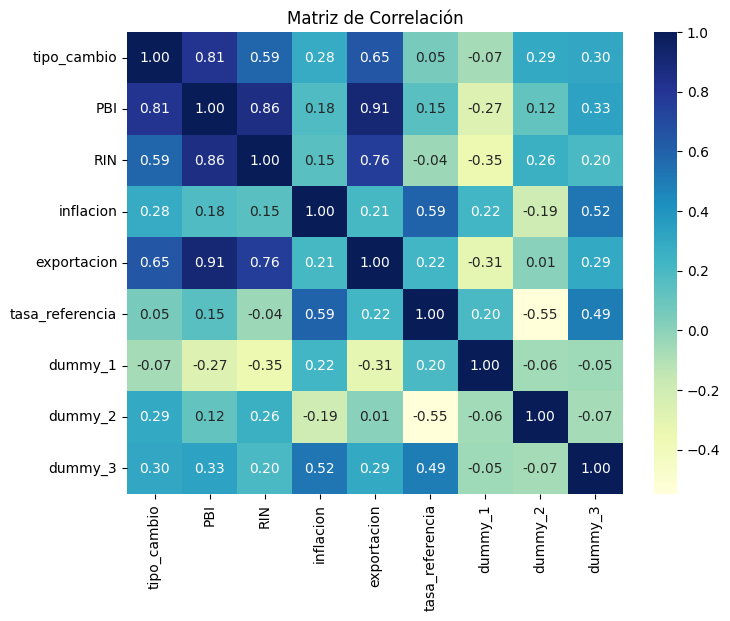

In [4]:
## B) MATRIZ DE CORRELACION
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

In [5]:
## B) TRANSFORMAR LOS DATOS A LN

df["ln_tipo_cambio"] = np.log(df["tipo_cambio"])
df["ln_PBI"] = np.log(df["PBI"])
df["ln_RIN"] = np.log(df["RIN"])
df["ln_inflacion"] = np.log(df["inflacion"].abs() + 1e-6)  # evita log(0) o negativos
df["ln_exportacion"] = np.log(df["exportacion"])
df["ln_tasa_referencia"] = np.log(df["tasa_referencia"])

# Eliminar las columnas originales
df = df.drop(columns=["tipo_cambio", "PBI", "RIN", "inflacion", "exportacion"])

print(df.head())

  tiempo  tasa_referencia  dummy_1  dummy_2  dummy_3  ln_tipo_cambio  \
0   T107         4.500000        0        0        0        1.157824   
1   T207         4.500000        0        0        0        1.153100   
2   T307         4.833333        0        0        0        1.126649   
3   T407         5.000000        0        0        0        1.098012   
4   T108         5.250000        0        0        0        1.010400   

      ln_PBI     ln_RIN  ln_inflacion  ln_exportacion  ln_tasa_referencia  
0  11.203054   9.821572     -0.878520        7.559174            1.504077  
1  11.297576   9.977110     -0.220928        7.714232            1.504077  
2  11.298489  10.035699      0.877039        7.842538            1.575536  
3  11.350563  10.228791      1.252047        7.885988            1.609438  
4  11.313416  10.421567      1.576579        7.863763            1.658228  


In [6]:
## C) ANALISIS DESCRIPTIVO
print(df.dtypes)
print("------------------------------")
print(df.isnull().sum())
print("------------------------------")
print(df.describe(include='all'))

tiempo                 object
tasa_referencia       float64
dummy_1                 int64
dummy_2                 int64
dummy_3                 int64
ln_tipo_cambio        float64
ln_PBI                float64
ln_RIN                float64
ln_inflacion          float64
ln_exportacion        float64
ln_tasa_referencia    float64
dtype: object
------------------------------
tiempo                0
tasa_referencia       0
dummy_1               0
dummy_2               0
dummy_3               0
ln_tipo_cambio        0
ln_PBI                0
ln_RIN                0
ln_inflacion          0
ln_exportacion        0
ln_tasa_referencia    0
dtype: int64
------------------------------
       tiempo  tasa_referencia    dummy_1    dummy_2    dummy_3  \
count      74        74.000000  74.000000  74.000000  74.000000   
unique     74              NaN        NaN        NaN        NaN   
top      T107              NaN        NaN        NaN        NaN   
freq        1              NaN        NaN        

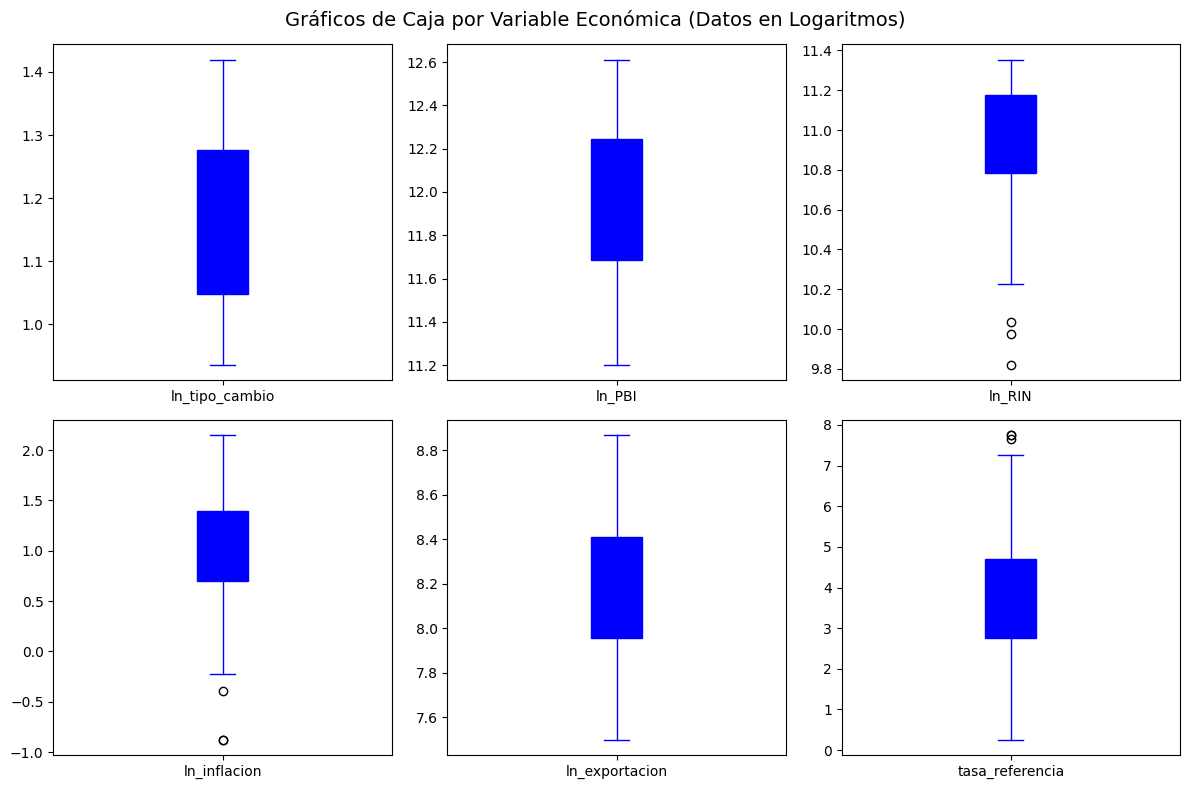

In [7]:
## D) GRAFICO DE CAJA

# Seleccion de las variables
variables_continuas = [
    "ln_tipo_cambio", "ln_PBI", "ln_RIN",
    "ln_inflacion", "ln_exportacion", "tasa_referencia"
]

# Crear los gráficos de caja
df[variables_continuas].plot(
    kind='box',
    subplots=True,
    layout=(2,3),
    figsize=(12,8),
    sharex=False,
    sharey=False,
    color='blue',
    patch_artist=True
)

plt.suptitle("Gráficos de Caja por Variable Económica (Datos en Logaritmos)", fontsize=14)
plt.tight_layout()
plt.show()


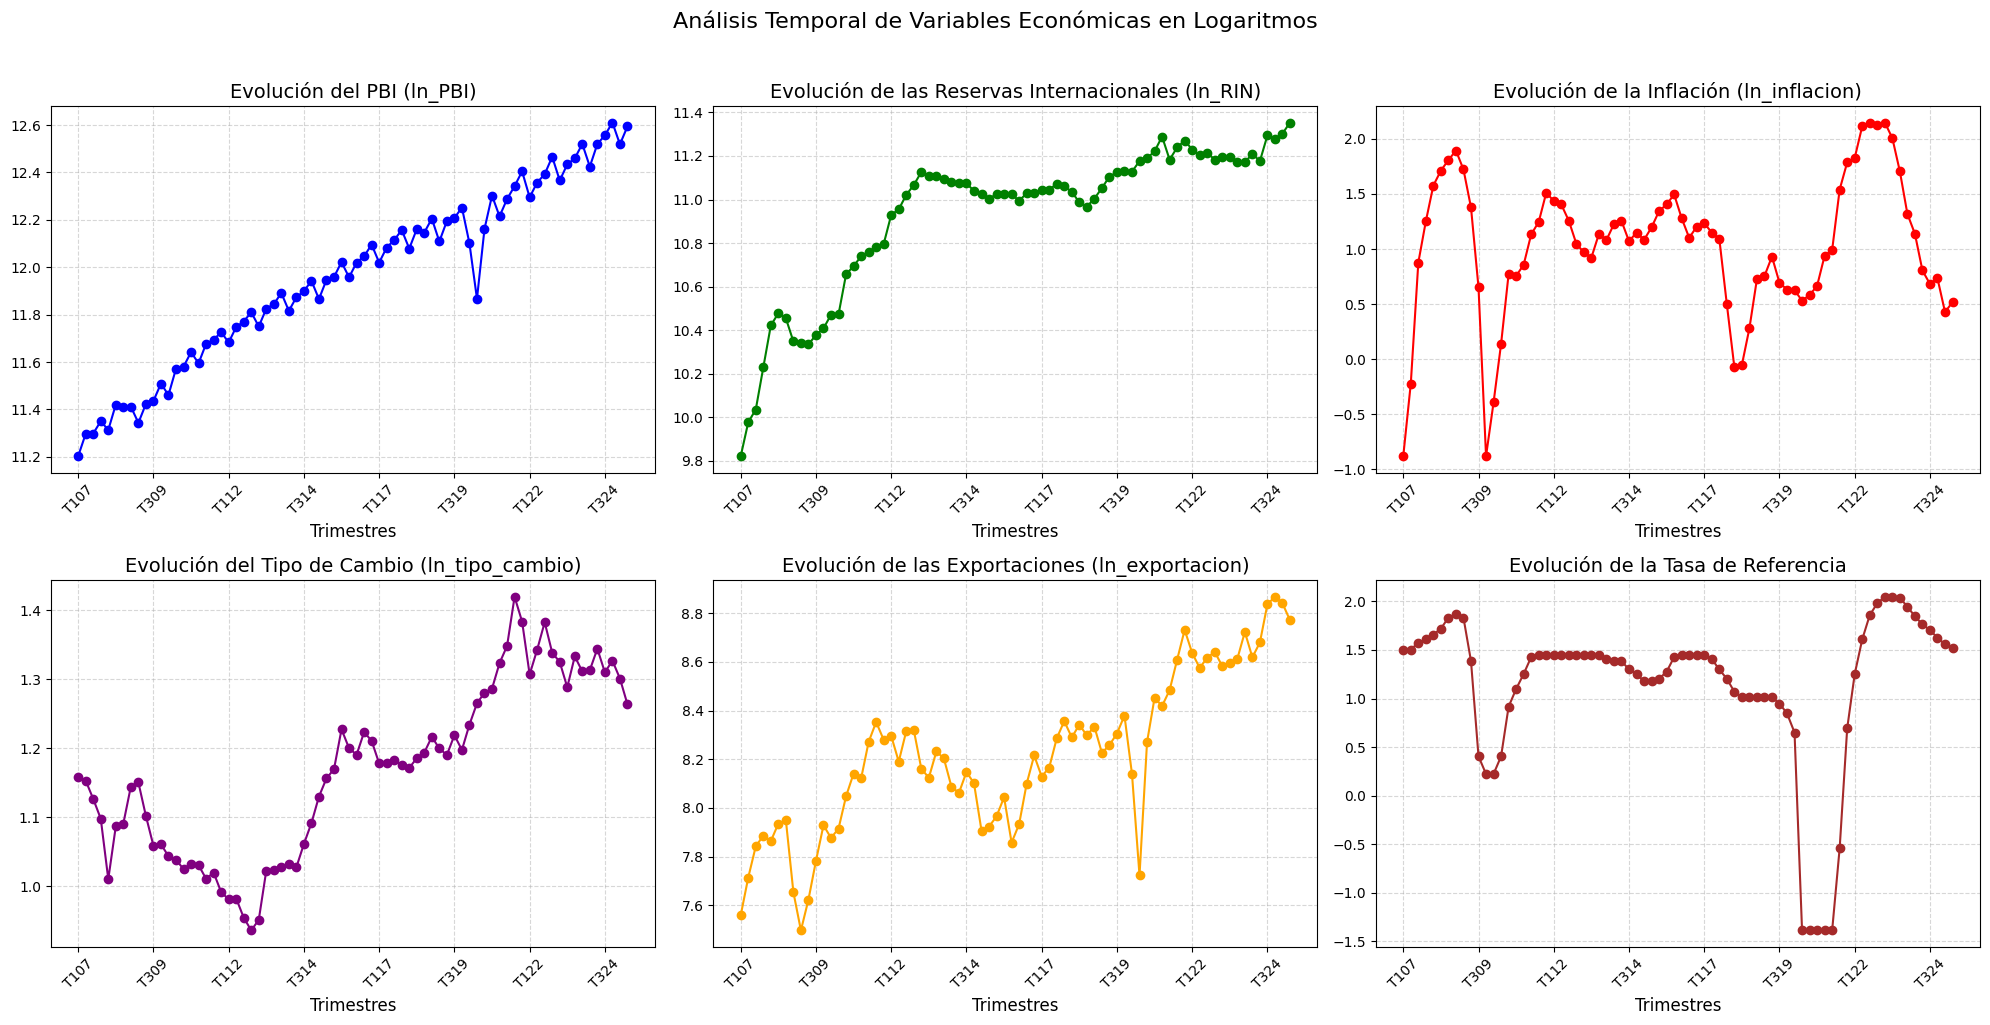

In [8]:
## E) ANÁLISIS DE LA SERIE EN EL TIEMPO (INCLUYE EXPORTACIONES Y TASA DE REFERENCIA)

# Crear subplots (2 filas, 3 columnas)
fig, axes = plt.subplots(2, 3, figsize=(20,10))

# Gráfico 1: PBI
axes[0,0].plot(df["tiempo"], df["ln_PBI"], marker="o", linestyle="-", color="blue")
axes[0,0].set_title("Evolución del PBI (ln_PBI)", fontsize=14)
axes[0,0].set_xlabel("Trimestres", fontsize=12)
axes[0,0].grid(True, linestyle="--", alpha=0.5)
axes[0,0].set_xticks(df["tiempo"][::10])
axes[0,0].tick_params(axis='x', rotation=45)

# Gráfico 2: Reservas Internacionales
axes[0,1].plot(df["tiempo"], df["ln_RIN"], marker="o", linestyle="-", color="green")
axes[0,1].set_title("Evolución de las Reservas Internacionales (ln_RIN)", fontsize=14)
axes[0,1].set_xlabel("Trimestres", fontsize=12)
axes[0,1].grid(True, linestyle="--", alpha=0.5)
axes[0,1].set_xticks(df["tiempo"][::10])
axes[0,1].tick_params(axis='x', rotation=45)

# Gráfico 3: Inflación
axes[0,2].plot(df["tiempo"], df["ln_inflacion"], marker="o", linestyle="-", color="red")
axes[0,2].set_title("Evolución de la Inflación (ln_inflacion)", fontsize=14)
axes[0,2].set_xlabel("Trimestres", fontsize=12)
axes[0,2].grid(True, linestyle="--", alpha=0.5)
axes[0,2].set_xticks(df["tiempo"][::10])
axes[0,2].tick_params(axis='x', rotation=45)

# Gráfico 4: Tipo de Cambio
axes[1,0].plot(df["tiempo"], df["ln_tipo_cambio"], marker="o", linestyle="-", color="purple")
axes[1,0].set_title("Evolución del Tipo de Cambio (ln_tipo_cambio)", fontsize=14)
axes[1,0].set_xlabel("Trimestres", fontsize=12)
axes[1,0].grid(True, linestyle="--", alpha=0.5)
axes[1,0].set_xticks(df["tiempo"][::10])
axes[1,0].tick_params(axis='x', rotation=45)

# Gráfico 5: Exportaciones
axes[1,1].plot(df["tiempo"], df["ln_exportacion"], marker="o", linestyle="-", color="orange")
axes[1,1].set_title("Evolución de las Exportaciones (ln_exportacion)", fontsize=14)
axes[1,1].set_xlabel("Trimestres", fontsize=12)
axes[1,1].grid(True, linestyle="--", alpha=0.5)
axes[1,1].set_xticks(df["tiempo"][::10])
axes[1,1].tick_params(axis='x', rotation=45)

# Gráfico 6: Tasa de Referencia
axes[1,2].plot(df["tiempo"], df["ln_tasa_referencia"], marker="o", linestyle="-", color="brown")
axes[1,2].set_title("Evolución de la Tasa de Referencia", fontsize=14)
axes[1,2].set_xlabel("Trimestres", fontsize=12)
axes[1,2].grid(True, linestyle="--", alpha=0.5)
axes[1,2].set_xticks(df["tiempo"][::10])
axes[1,2].tick_params(axis='x', rotation=45)

plt.suptitle("Análisis Temporal de Variables Económicas en Logaritmos", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


## 5. Estimación del modelo

In [9]:
# Definir variables independientes y dependiente
X = df[["ln_PBI", "ln_RIN", "ln_inflacion", "ln_exportacion", "ln_tasa_referencia","dummy_1", "dummy_2", "dummy_3"]]
y = df["ln_tipo_cambio"]

# Agregar constante para el intercepto
X = sm.add_constant(X)

# Crear modelo y ajustar
modelo = sm.OLS(y, X).fit()

# Resumen del modelo
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:         ln_tipo_cambio   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     82.21
Date:                Mon, 27 Oct 2025   Prob (F-statistic):           5.25e-31
Time:                        16:06:45   Log-Likelihood:                 138.68
No. Observations:                  74   AIC:                            -259.4
Df Residuals:                      65   BIC:                            -238.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.0938      0

## 6. Diagnósticos econométricos

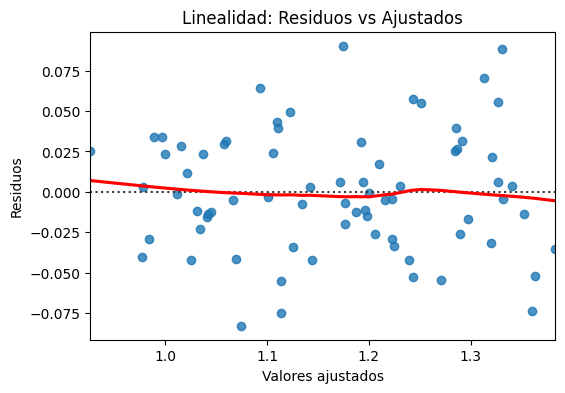

In [10]:
# 1. Linealidad (gráfico residuos vs valores ajustados)
plt.figure(figsize=(6,4))
sns.residplot(x=modelo.fittedvalues, y=modelo.resid, lowess=True, line_kws={"color":"red"})
plt.xlabel("Valores ajustados")
plt.ylabel("Residuos")
plt.title("Linealidad: Residuos vs Ajustados")
plt.show()


Test Shapiro-Wilk:
Estadístico: 0.9904974848722033  | p-value: 0.857991345707077
✅ Normalidad (no se rechaza H0)


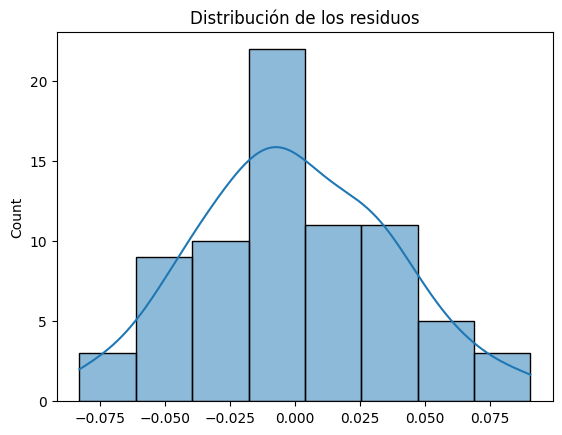

In [11]:
# 2. Normalidad de errores
# Shapiro-Wilk
stat_shapiro, p_shapiro = shapiro(modelo.resid)
print("\nTest Shapiro-Wilk:")
print("Estadístico:", stat_shapiro, " | p-value:", p_shapiro)
if p_shapiro > 0.05:
    print("✅ Normalidad (no se rechaza H0)")
else:
    print("❌ No normalidad (se rechaza H0)")

sns.histplot(modelo.resid, kde=True)
plt.title("Distribución de los residuos")
plt.show()

In [12]:
from statsmodels.stats.stattools import jarque_bera

# Prueba Jarque-Bera
jb_stat, jb_pvalue, skew, kurtosis = jarque_bera(modelo.resid)

print("Test Jarque-Bera:")
print("Estadístico JB:", jb_stat)
print("p-value:", jb_pvalue)
print("Skewness:", skew)
print("Kurtosis:", kurtosis)

if jb_pvalue > 0.05:
    print("✅ Normalidad (no se rechaza H0)")
else:
    print("❌ No normalidad (se rechaza H0)")


Test Jarque-Bera:
Estadístico JB: 0.48198638700156043
p-value: 0.7858469752369659
Skewness: 0.15240706161510248
Kurtosis: 2.748190032808062
✅ Normalidad (no se rechaza H0)


In [13]:
# 3. Homocedasticidad (Breusch-Pagan): Los errores tienen la misma varianza en todas las observaciones
bp_test = het_breuschpagan(modelo.resid, modelo.model.exog)
labels = ["LM Statistic","LM-Test p-value","F-Statistic","F-Test p-value"]
results = dict(zip(labels, bp_test))

print("\nTest de Breusch-Pagan (Homocedasticidad):")
print(results)

if results["LM-Test p-value"] > 0.05:
    print("✅ Se cumple homocedasticidad (no se rechaza H0).")
else:
    print("❌ No se cumple homocedasticidad (se rechaza H0).")


Test de Breusch-Pagan (Homocedasticidad):
{'LM Statistic': np.float64(18.576992266725437), 'LM-Test p-value': np.float64(0.017293142625725486), 'F-Statistic': np.float64(2.723382731113036), 'F-Test p-value': np.float64(0.011850637807056136)}
❌ No se cumple homocedasticidad (se rechaza H0).


In [14]:
from statsmodels.stats.diagnostic import het_goldfeldquandt
# El Test de Goldfeld-Quandt detecta heterocedasticidad evaluada respecto a una variable específica,
# Es útil cuando se sospecha que la varianza cambia sistemáticamente con esa variable específica.

# Test de Goldfeld-Quandt
gq_test = het_goldfeldquandt(modelo.resid, modelo.model.exog)
labels_gq = ["F-Statistic","p-value","Alternative"]
results_gq = dict(zip(labels_gq, gq_test))

print("\nTest de Goldfeld-Quandt (Homocedasticidad):")
print(results_gq)

if results_gq["p-value"] > 0.05:
    print("✅ Se cumple homocedasticidad (no se rechaza H0).")
else:
    print("❌ No se cumple homocedasticidad (se rechaza H0).")



Test de Goldfeld-Quandt (Homocedasticidad):
{'F-Statistic': np.float64(1.4307603161772764), 'p-value': np.float64(0.16881921530204466), 'Alternative': 'increasing'}
✅ Se cumple homocedasticidad (no se rechaza H0).



Prueba Durbin-Watson:
Estadístico DW: 1.8815
No hay evidencia fuerte de autocorrelación.


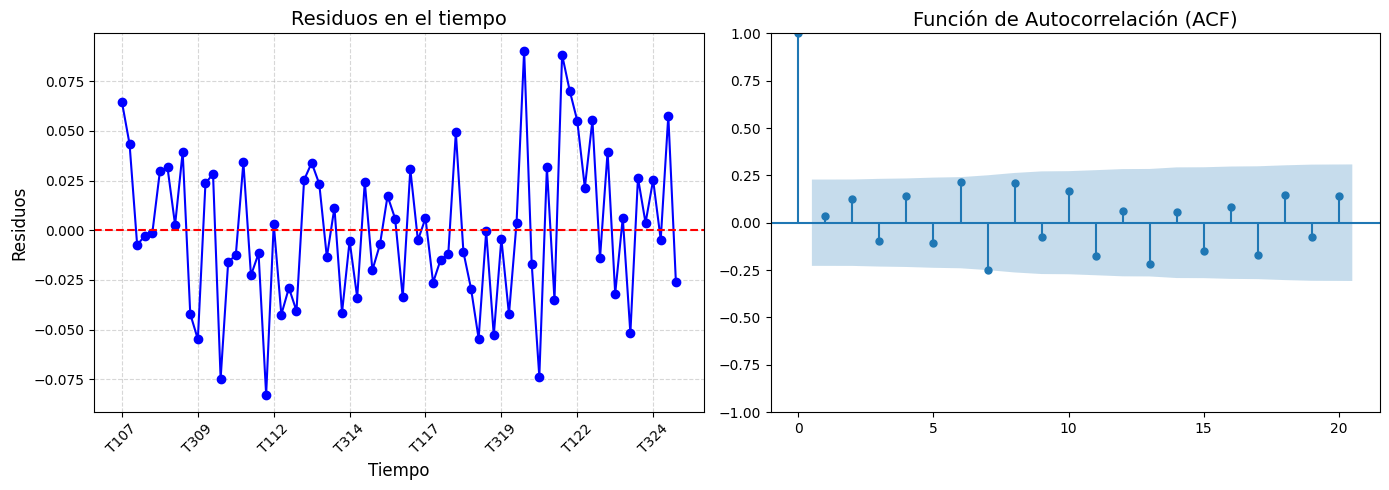

In [15]:
# 4. Durbin-Watson
dw_stat = durbin_watson(modelo.resid)

print("\nPrueba Durbin-Watson:")
print("Estadístico DW:", round(dw_stat, 4))

# Interpretación
if dw_stat < 1.5:
    print("Posible autocorrelación positiva de los residuos.")
elif dw_stat > 2.5:
    print("Posible autocorrelación negativa de los residuos.")
else:
    print("No hay evidencia fuerte de autocorrelación.")

# Crear figura con 2 gráficos
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ===============================
# Gráfico 1: Residuos en el tiempo
axes[0].plot(df["tiempo"], modelo.resid, marker="o", linestyle="-", color="blue")
axes[0].axhline(y=0, color="red", linestyle="--")
axes[0].set_title("Residuos en el tiempo", fontsize=14)
axes[0].set_xlabel("Tiempo", fontsize=12)
axes[0].set_ylabel("Residuos", fontsize=12)
axes[0].grid(True, linestyle="--", alpha=0.5)


axes[0].set_xticks(df["tiempo"][::10])
axes[0].tick_params(axis='x', rotation=45)

# ===============================
# Gráfico 2: Autocorrelación (ACF)
sm.graphics.tsa.plot_acf(modelo.resid, lags=20, ax=axes[1])
axes[1].set_title("Función de Autocorrelación (ACF)", fontsize=14)

plt.tight_layout()
plt.show()


# 7. Interpretación económica

# Resumen interpretativo del modelo OLS (ln_tipo_cambio como dependiente)

* **R² = 0.910:** El modelo explica el 91% de la variabilidad del tipo de cambio, indicando un ajuste muy sólido.  

* **Prob (F-statistic) = 5.25e-31:** El modelo es globalmente significativo.  

* **Constante (β₀ = -1.094):** Ajusta el nivel base del tipo de cambio en logaritmos.  

* **ln_PBI (β₁ = 0.693, p = 0.000):** Un aumento del 1% en el PBI eleva el tipo de cambio en 0.693%.  

* **ln_RIN (β₂ = -0.445, p = 0.000):** Un aumento del 1% en reservas internacionales reduce el tipo de cambio en 0.445%.  

* **ln_inflación (β₃ = 0.065, p = 0.000):** Un aumento del 1% en inflación incrementa el tipo de cambio en 0.065%.  

* **ln_exportación (β₄ = -0.144, p = 0.000):** Un aumento del 1% en exportaciones reduce el tipo de cambio en 0.144%.  

* **ln_tasa_referencia (β₅ = -0.036, p = 0.001):** Un aumento del 1% en la tasa de referencia reduce el tipo de cambio en 0.036%.  

* **Dummy_1:** No significativa.  

* **Dummy_2:** Positiva y significativa al 10%, refleja periodos de apreciación del tipo de cambio.  

* **Dummy_3:** Negativa y no significativa, indica ligera depreciación.  

* **Durbin-Watson = 1.881:** No hay evidencia fuerte de autocorrelación de residuos.  




# 8. Conclusiones


- El modelo explica el 91% de la variabilidad del tipo de cambio, mostrando que PBI, reservas internacionales, inflación, exportaciones, tasa de referencia y dummies son relevantes para su comportamiento en el Perú (2007–2025).

- El PBI y la inflación elevan el tipo de cambio, mientras que mayores reservas internacionales, exportaciones y una tasa de referencia más alta lo reducen, reflejando la interacción típica del modelo Mundell-Fleming entre variables macroeconómicas y el mercado de divisas.

- Las variables de control (dummies) indican episodios específicos de apreciación o depreciación, aunque su efecto es menor que el de las variables económicas principales.

- El modelo es robusto: no presenta autocorrelación significativa de residuos, cumple con normalidad de errores según el test Jarque-Bera  y homocedasticidad según el test Goldfeld-Quandt, lo que permite interpretar confiablemente las relaciones entre tipo de cambio y las variables macroeconómicas estudiadas.